In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import MobileNetV2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

import os
import time
import shutil
import pathlib
import itertools

2025-04-21 16:04:00.734345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 16:04:01.067186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # check if there are another folders
            if pathlib.Path(foldpath).suffix == '':
                # check unneeded masks
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)

            else:            
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img / 255.0

    tr_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [4]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Greens):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [6]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i]      # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [7]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    
    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        # Add any additional logic you need here
        self._model = value

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = "n" #input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, learning_rate) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, learning_rate) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [8]:
# data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
data_dir = './COVID-19_Radiography_Dataset/'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 64
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 14815 validated image filenames belonging to 4 classes.
Found 3175 validated image filenames belonging to 4 classes.
Found 3175 validated image filenames belonging to 4 classes.


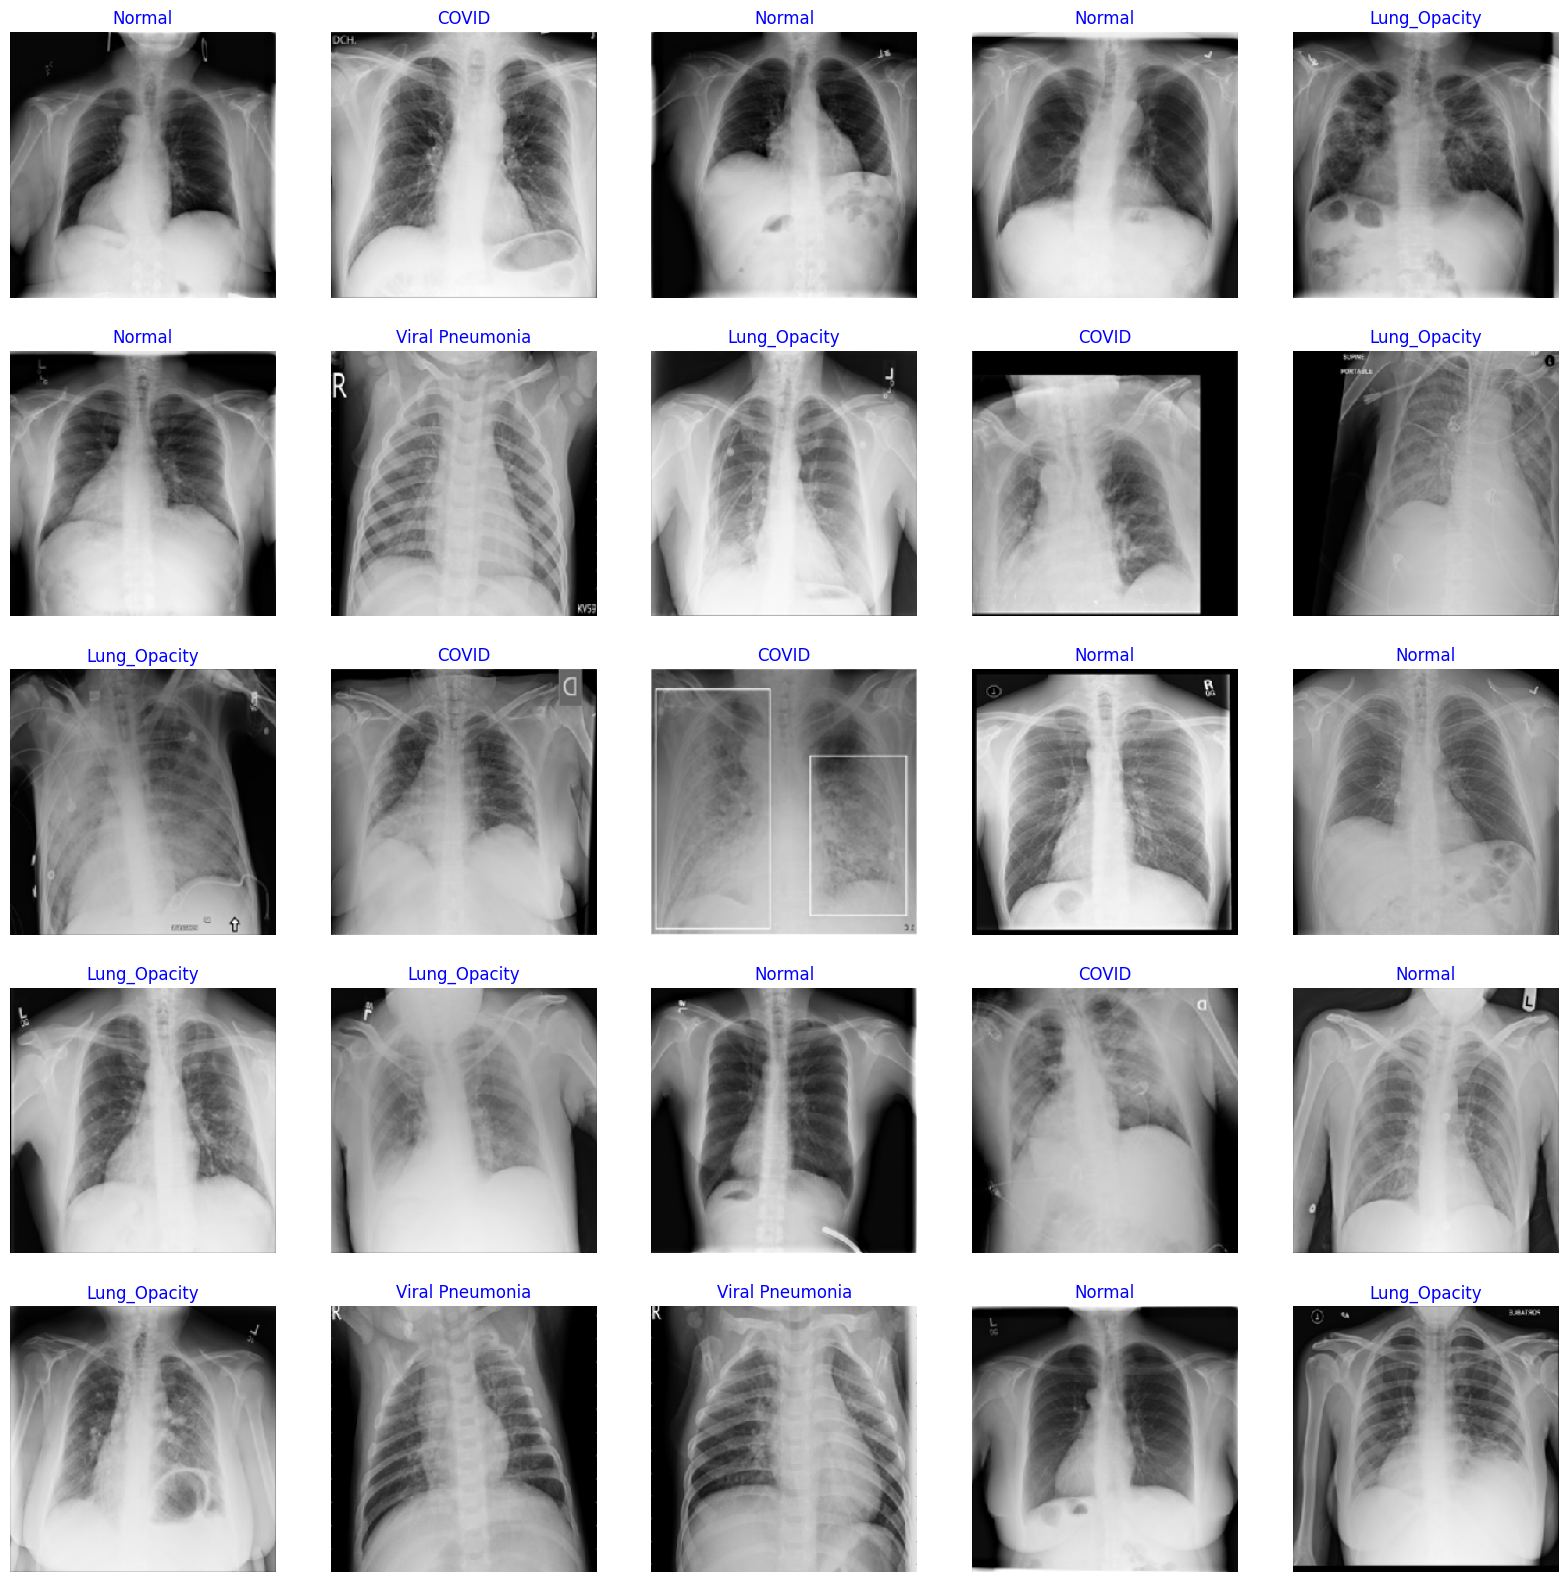

In [9]:
show_images(train_gen)

In [10]:
#3 & 4. Load Pre-trained MobileNetV2

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

def getBaseModel():
    base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape= img_shape
    )
    return base_model
base_model = getBaseModel()
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
# 5. Replace Fully Connected Layers

# Create Model Structure
num_classes =  len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


model = keras.Sequential(
    [
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

#model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [12]:
# 6. Total Parameters

# total_params = model.count_params()
# print(f"Total Parameters: {total_params}")



# Assuming 'model' is your Keras model
model.build(input_shape=(None, *(224, 224, 3)))  # Provide the input shape here
total_params = model.count_params()
print(f"Total Parameters: {total_params}")

Total Parameters: 67011140


In [13]:
# 7. Print Architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    64,226,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,011,140 (255.63 MB)

 Trainable params: 66,977,028 (255.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
batch_size = 64   #batch size for training
epochs = 20  # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 50   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))   # number of training batch to run per epoch
print(f'Number of batches in training: {batches*batch_size}')

Number of batches in training: 14848


In [15]:
# 8. Retrain with Transfer Learning

def getBaseModel():
    img_shape = (224, 224, 3)  # or use your img_size and channels
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_shape=img_shape
    )
    base_model.build(input_shape=(None, *img_shape))  # Ensure the base model is built
    return base_model

def train_model(model):

    # Compile and train model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    print(model.summary())
    callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

    history = model.fit(
       x= train_gen, epochs= epochs, batch_size= batch_size, callbacks= callbacks,
                   validation_data= valid_gen, validation_steps= None, shuffle= False, verbose=0
     )
    return history


# define a function to set number of trainable layers
def set_trainable_layers(trainable_layers):
    # Freeze base model layers
    tempBASEMODEL = getBaseModel()
    for layer in tempBASEMODEL.layers:
        layer.trainable = False

    # Unfreeze specific layers
    if trainable_layers == 4:
        for layer in tempBASEMODEL.layers[-3:]:
            layer.trainable = True
            print(f"Layer {layer.name} is trainable")
    elif trainable_layers == 5:
        for layer in tempBASEMODEL.layers[-5:]:
            layer.trainable = True
            print(f"Layer {layer.name} is trainable")

    model = keras.Sequential(
    [
        tempBASEMODEL,
        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
    )

    return model

In [16]:
model1 = set_trainable_layers( trainable_layers=3) # Last 3 FC layers
model2 = set_trainable_layers( trainable_layers=4) # 1 Conv + 3 FC layers
model3 = set_trainable_layers( trainable_layers=5)  # 2 Conv + 3 FC layers

Layer Conv_1 is trainable
Layer Conv_1_bn is trainable
Layer out_relu is trainable
Layer block_16_project is trainable
Layer block_16_project_BN is trainable
Layer Conv_1 is trainable
Layer Conv_1_bn is trainable
Layer out_relu is trainable


In [17]:

# Train with different sets of trainable layers
history_3 = train_model(model1)  # Last 3 FC layers


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     2.230   80.452   0.39264  86.803   0.00100  0.00100  accuracy     0.00    648.20 
 2 /20     0.269   90.395   0.26717  90.646   0.00100  0.00100  val_loss    31.96    592.73 
 3 /20     0.194   92.744   0.29910  90.079   0.00100  0.00100  val_loss    -11.95   612.63 
 4 /20     0.178   93.621   0.30527  89.953   0.00100  0.00100  val_loss    -14.26   457.89 


AttributeError: 'Adam' object has no attribute 'lr'

In [ ]:
history_4 = train_model(model2)  # 1 Conv + 3 FC layers

In [ ]:
history_5 = train_model(model3)  # 2 Conv + 3 FC layers

In [ ]:

# 9. Evaluation and Comparison

# (Code for calculating accuracy, recall, precision, F1-score, sensitivity,
# and plotting convergence curves would go here)

In [ ]:
model1.save(f'saved_model/Model{1}.h5', save_format="h5")
model2.save(f'saved_model/Model{2}.h5', save_format="h5")
model3.save(f'saved_model/Model{3}.h5', save_format="h5")

In [ ]:
!ls /kaggle/working/saved_model
from IPython.display import FileLink
display(FileLink("saved_model/Model1.h5"))
display(FileLink("saved_model/Model2.h5"))
display(FileLink("saved_model/Model3.h5"))


Model1	Model1.h5  Model2  Model2.h5  Model3  Model3.h5


/kaggle/working/saved_model/Model1.h5

/kaggle/working/saved_model/Model2.h5

/kaggle/working/saved_model/Model3.h5

Model_1


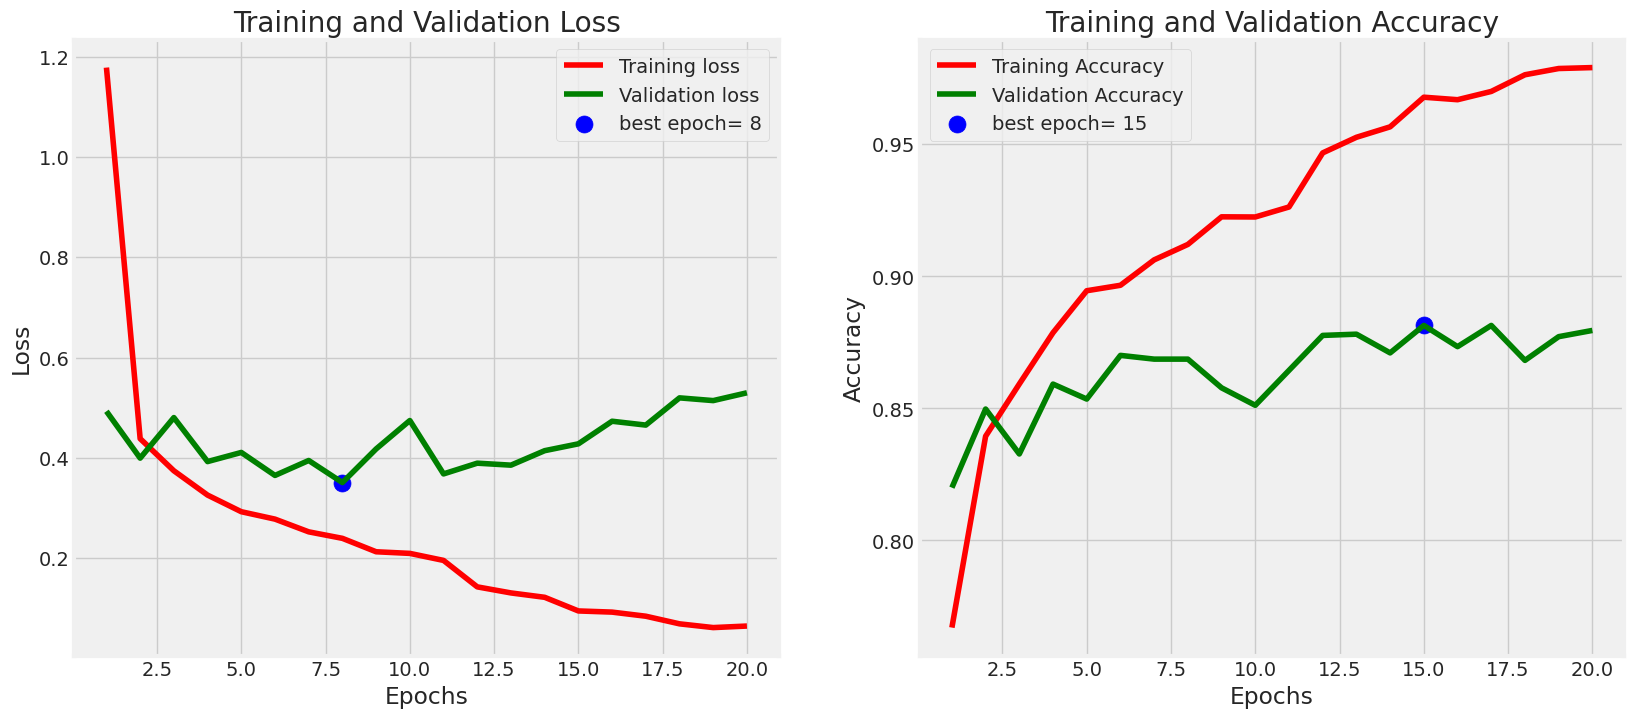

Model_2


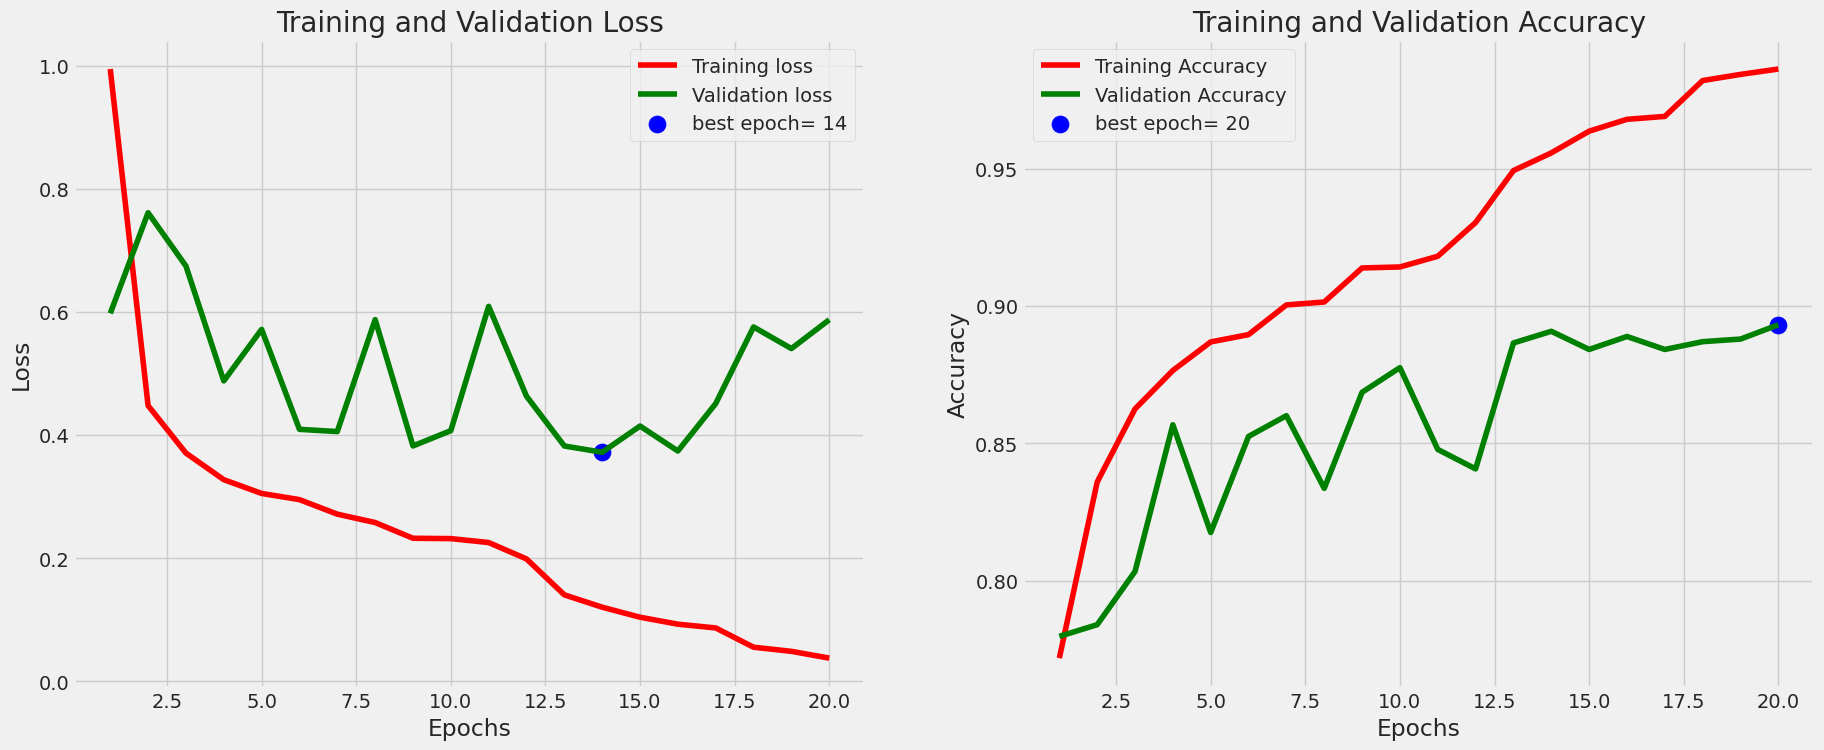

Model_3


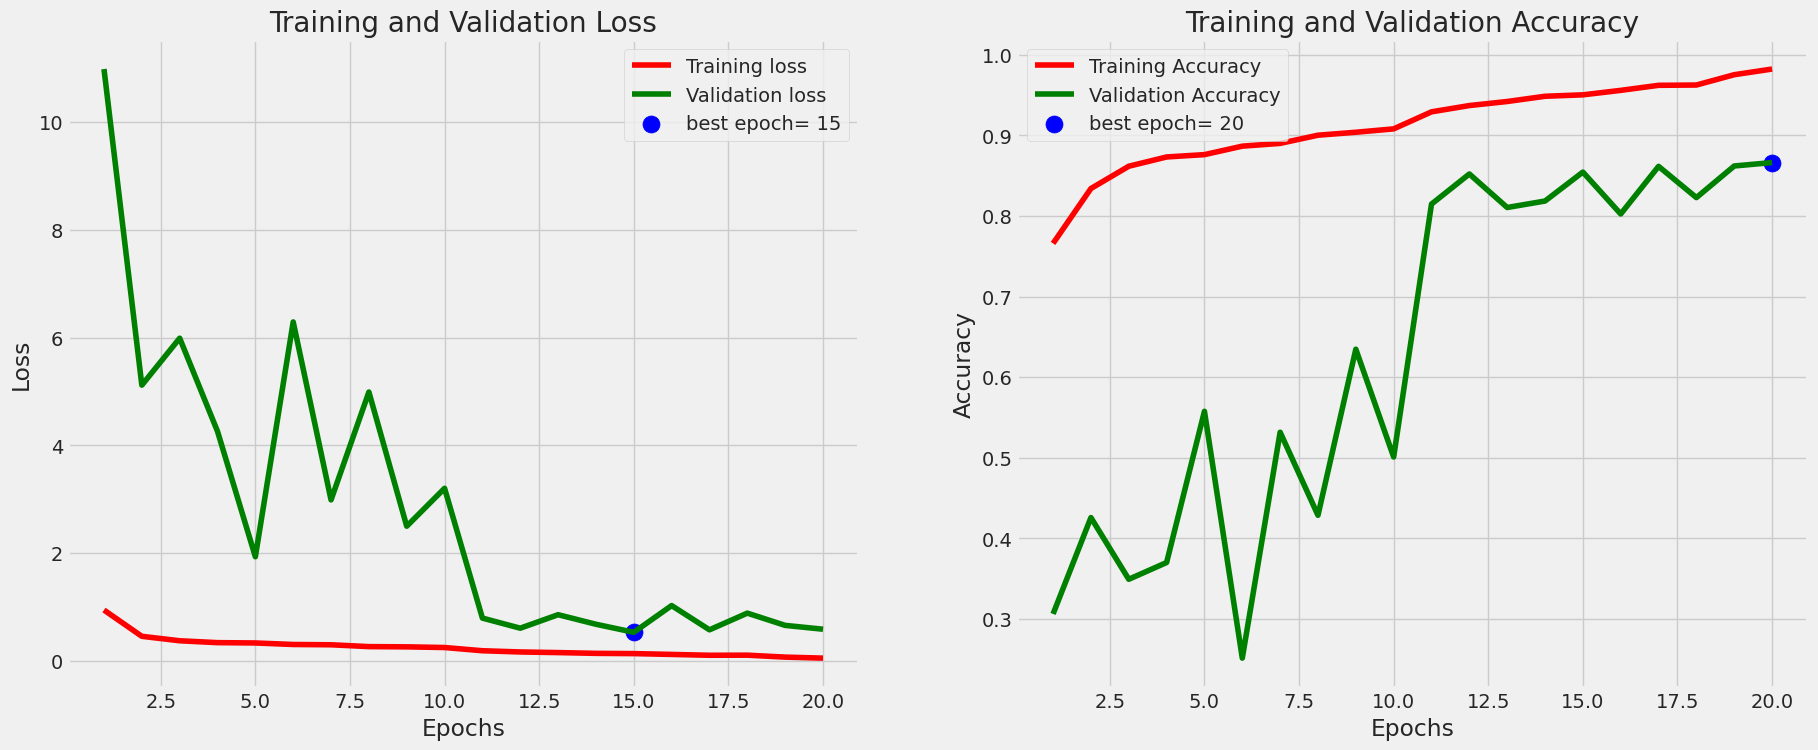

In [ ]:
history = [history_3, history_4, history_5 ]
i = 1
for his in history:
    print(f'Model_{i}')
    plot_training(his)
    i+=1

In [ ]:
models = [model1, model2, model3]
i =1
for model in models:
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
    print(f"===========model_{i}==============" )
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print("=========================" )
    i+=1

29/29 [==============================] - 20s 678ms/step - loss: 0.3419 - accuracy: 0.8781
===========model_1==============
Train Loss:  0.2619060277938843
Train Accuracy:  0.9051724076271057
--------------------
Validation Loss:  0.3450435996055603
Validation Accuracy:  0.8620689511299133
--------------------
Test Loss:  0.3418533205986023
Test Accuracy:  0.8781294226646423
29/29 [==============================] - 8s 282ms/step - loss: 0.3341 - accuracy: 0.9017
===========model_2==============
Train Loss:  0.08808482438325882
Train Accuracy:  0.9698275923728943
--------------------
Validation Loss:  0.46028727293014526
Validation Accuracy:  0.8728448152542114
--------------------
Test Loss:  0.334089070558548
Test Accuracy:  0.9017477631568909
29/29 [==============================] - 8s 267ms/step - loss: 0.5104 - accuracy: 0.8715
===========model_3==============
Train Loss:  0.23283062875270844
Train Accuracy:  0.920258641242981
--------------------
Validation Loss:  0.580291748046875

In [ ]:
Preds = {}
i = 1
for model in models:
    preds = model.predict_generator(test_gen)
    y_pred = np.argmax(preds, axis=1)
    Preds[f"Model{i}"] = y_pred
    i+=1

print(Preds)

{'Model1': array([1, 1, 1, ..., 2, 2, 2]), 'Model2': array([1, 1, 1, ..., 2, 2, 2]), 'Model3': array([1, 1, 1, ..., 2, 2, 2])}


===============Model 1===============
Confusion Matrix, Without Normalization
[[300  17  42   3]
 [  9 481 112   0]
 [ 11  53 952   3]
 [  1   0   7 126]]
                 precision    recall  f1-score   support

          COVID       0.93      0.83      0.88       362
   Lung_Opacity       0.87      0.80      0.83       602
         Normal       0.86      0.93      0.89      1019
Viral Pneumonia       0.95      0.94      0.95       134

       accuracy                           0.88      2117
      macro avg       0.90      0.88      0.89      2117
   weighted avg       0.88      0.88      0.88      2117

===============Model 2===============
Confusion Matrix, Without Normalization
[[331  13  15   3]
 [  6 505  91   0]
 [  9  65 944   1]
 [  0   0   5 129]]
                 precision    recall  f1-score   support

          COVID       0.96      0.91      0.94       362
   Lung_Opacity       0.87      0.84      0.85       602
         Normal       0.89      0.93      0.91      1019
Vi

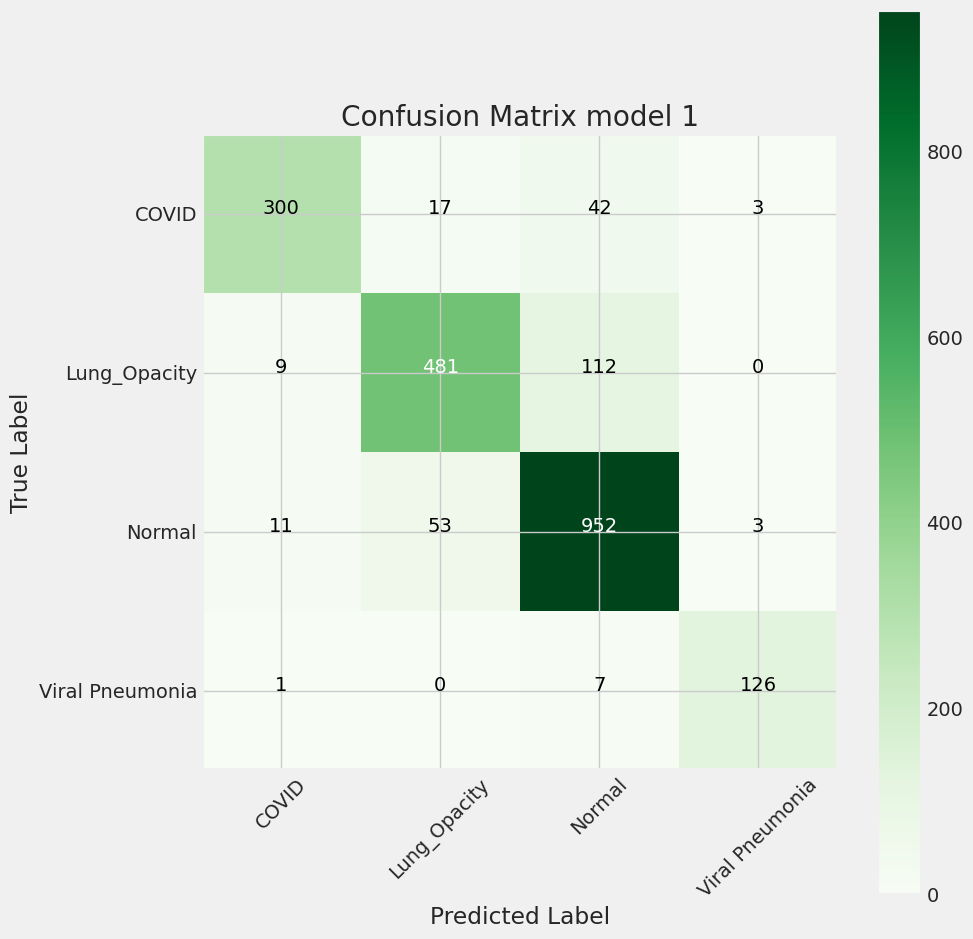

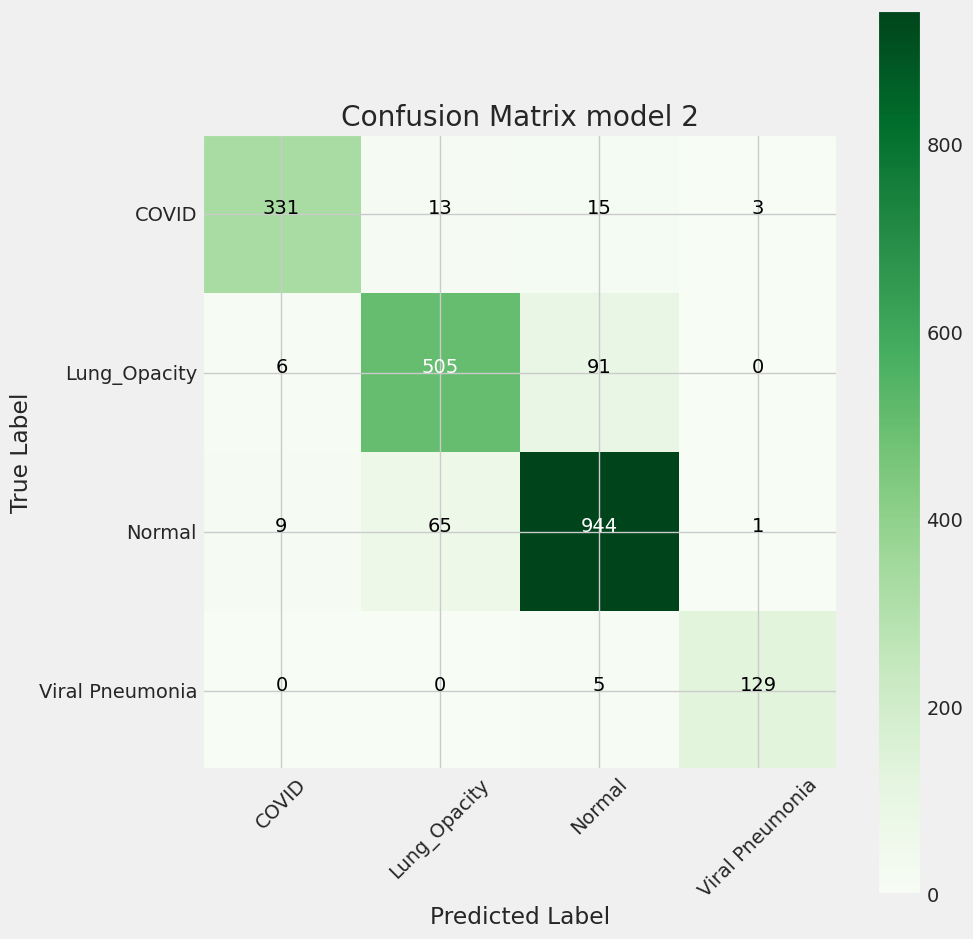

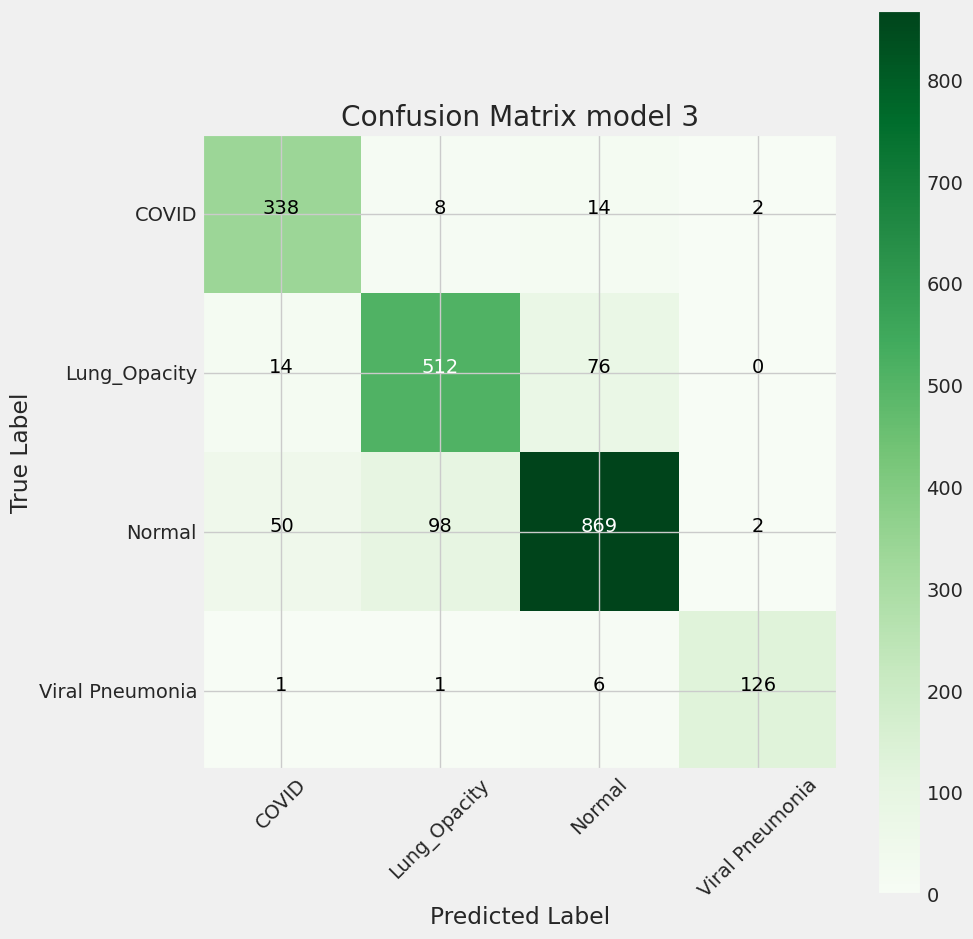

In [ ]:
i =1
for model in models:
    print(f"===============Model {i}===============")
    y_pred = Preds[f"Model{i}"]
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = f'Confusion Matrix model {i}')

    # Classification report
    print(classification_report(test_gen.classes, y_pred, target_names= classes))
    i+=1
    print("===============================")